#### IMPORT THƯ VIỆN CẦN THIẾT

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime, time
import holidays
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()

#  CHUẨN BỊ DỮ LIỆU

## Đọc dữ liệu từ file

In [3]:
train_data = pd.read_csv('train.csv', index_col='date')  
test_data = pd.read_csv('test.csv', index_col='date')  

#### TẠO LAG CHO SẢN LƯỢNG:
- Tạo các lag 6, 7, 14, 21 

In [6]:
lags = [6, 7, 14, 21]
# Tạo các cột lag tương ứng
for lag in lags:
    train_data[f'new_total_usage_lag{lag}'] = train_data['new_total_usage'].shift(lag)
    test_data[f'new_total_usage_lag{lag}'] = test_data['new_total_usage'].shift(lag)



In [ ]:
total_usage_df.head()

,date,total_usage,is_holiday,temperature,weekday,fill_zeros_usage,new_total_usage,new_total_usage_lag6,new_total_usage_lag7,new_total_usage_lag14,new_total_usage_lag21
0,2022-01-01,1.36,True,21.89,5,1.36,1496.0,NaN,NaN,NaN,NaN
1,2022-01-02,1.07,False,21.96,6,1.07,1177.0,NaN,NaN,NaN,NaN
2,2022-01-03,1.33,True,21.99,0,1.33,1463.0,NaN,NaN,NaN,NaN
3,2022-01-04,3.67,False,22.57,1,3.67,4037.0,NaN,NaN,NaN,NaN
4,2022-01-05,3.81,False,22.97,2,3.81,4191.0,NaN,NaN,NaN,NaN


Xóa những record có lag bị na

In [9]:
columns_to_check = [f'new_total_usage_lag{lag}' for lag in lags]

# Xóa các bản ghi bị NaN trong các cột lag
train_data.dropna(inplace=True, subset=columns_to_check)
test_data.dropna(inplace=True, subset=columns_to_check)

In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169 entries, 2024-01-22 to 2024-07-08
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   is_holiday             169 non-null    bool   
 1   temperature            169 non-null    float64
 2   new_total_usage        169 non-null    float64
 3   weekday_0              169 non-null    bool   
 4   weekday_1              169 non-null    bool   
 5   weekday_2              169 non-null    bool   
 6   weekday_3              169 non-null    bool   
 7   weekday_4              169 non-null    bool   
 8   weekday_5              169 non-null    bool   
 9   weekday_6              169 non-null    bool   
 10  new_total_usage_lag6   169 non-null    float64
 11  new_total_usage_lag7   169 non-null    float64
 12  new_total_usage_lag14  169 non-null    float64
 13  new_total_usage_lag21  169 non-null    float64
dtypes: bool(8), float64(6)
memory usage: 10.6+ KB


#### DỰ ĐOÁN BẰNG MÔ HÌNH MACHINE LEARNING: LINEAR REGRESSION, DECISION TREE, RANDOM FOREST

In [12]:
X_train = train_data.drop(columns=['new_total_usage'])  # Bỏ cột 'new_total_usage' để lấy X_train
y_train = train_data['new_total_usage']  # Lấy cột 'new_total_usage' làm y_train


X_test = test_data.drop(columns=['new_total_usage'])  # Bỏ cột 'new_total_usage' để lấy X_test
y_test = test_data['new_total_usage']  # Lấy cột 'new_total_usage' làm y_test

In [13]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (709, 13)
y_train shape: (709,)
X_test shape: (169, 13)
y_test shape: (169,)


In [14]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f'{model_name} - MAE: {mae}')
    print(f'{model_name} - MSE: {mse}')
    print(f'{model_name} - RMSE: {rmse}')
    print(f'{model_name} - MAPE: {mape}')

    plt.figure(figsize=(12, 6))
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend()
    plt.title(f'Actual vs Predicted Production ({model_name})')
    plt.show()

Random Forest - MAE: 498.2257988165734
Random Forest - MSE: 671044.6939763495
Random Forest - RMSE: 819.1731770366688
Random Forest - MAPE: 18.022834977209854


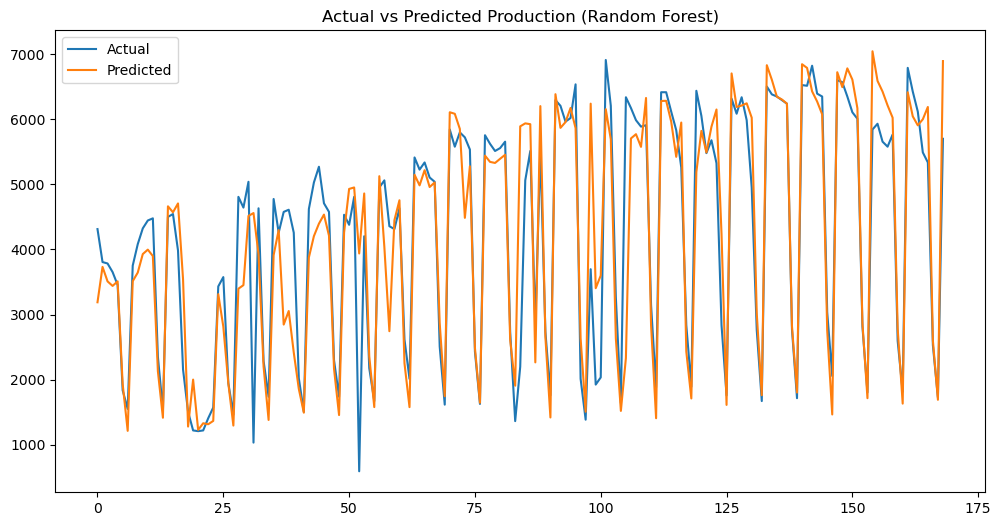

Decision Tree - MAE: 732.5739644970048
Decision Tree - MSE: 1433776.2544378238
Decision Tree - RMSE: 1197.4039645991757
Decision Tree - MAPE: 24.844383081172975


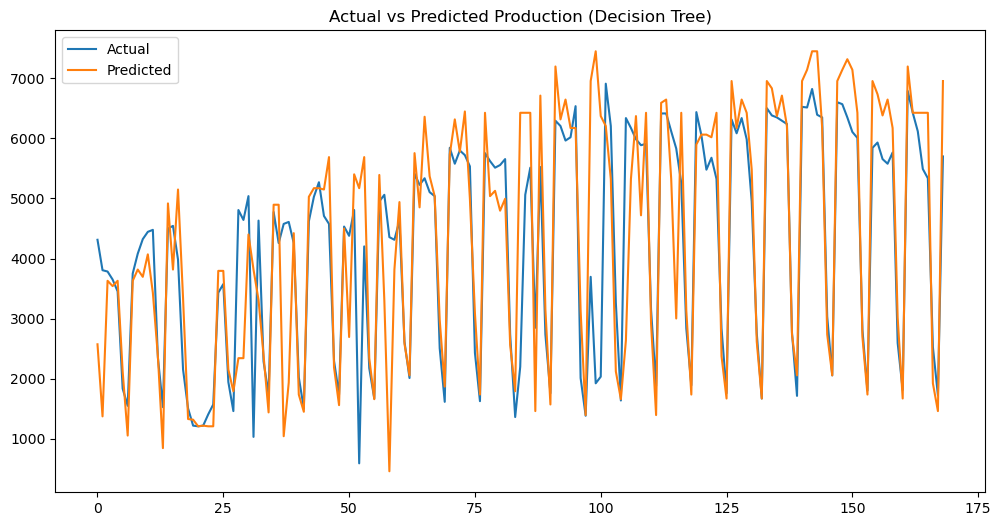

Linear Regression - MAE: 615.032195428444
Linear Regression - MSE: 745310.1487186633
Linear Regression - RMSE: 863.3134707153962
Linear Regression - MAPE: 23.99749555870296


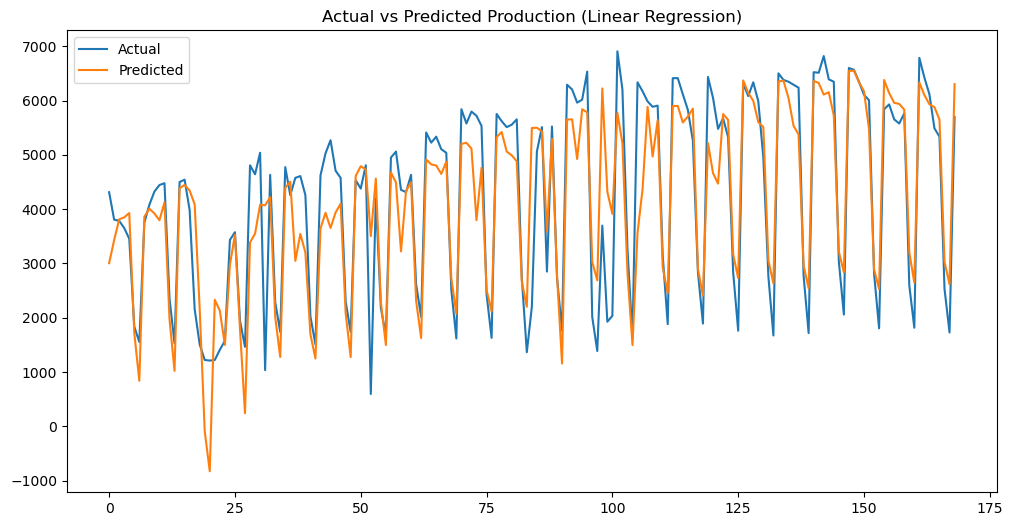

In [15]:
#Random Forest
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
evaluate_model(random_forest_model, X_train, X_test, y_train, y_test, 'Random Forest')
# Decision Tree
decision_tree_model = DecisionTreeRegressor(random_state=42)
evaluate_model(decision_tree_model, X_train, X_test, y_train, y_test, 'Decision Tree')

# Linear Regression
linear_regression_model = LinearRegression()
evaluate_model(linear_regression_model, X_train, X_test, y_train, y_test, 'Linear Regression')

##### Nhận xét
- Sơ bộ, các mô hình Machine Learning cho sai số rất cao, nên chuyển sang các mô hình khác 